## 2layer-nn

In [25]:
import numpy as np
import struct
import os

class NeuralNetwork:
    
    def __init__(self, input_dim, hidden_dim, output_dim, lr=0.1, reg_lambda=0.01):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lr = lr
        self.reg_lambda = reg_lambda
        
        #Initial weight
        self.W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
        self.b2 = np.zeros((1, output_dim))
    
    def forward(self, X):
        self.z1 = X.dot(self.W1) + self.b1
        self.a1 = np.maximum(0, self.z1)
        self.z2 = self.a1.dot(self.W2) + self.b2
        exp_scores = np.exp(self.z2)
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return self.probs
    
    def backward(self, X, y):
        num_examples = X.shape[0]
        
         # Compute loss
        cross_entropy_loss = -np.log(self.probs[range(num_examples), y])
        data_loss = np.sum(cross_entropy_loss) 
        reg_loss = 0.5 * self.reg_lambda * (np.sum(self.W1 * self.W1) + np.sum(self.W2 * self.W2))
        loss = data_loss + reg_loss
        
        # Compute gradient
        delta3 = self.probs
        delta3[range(num_examples), y] -= 1
        dW2 = (self.a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(self.W2.T) * (self.a1 > 0)
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        dW2 += self.reg_lambda * self.W2
        dW1 += self.reg_lambda * self.W1
        return dW1, db1, dW2, db2, loss
    
    def train(self, X, y, num_epochs=100, batch_size=32, decay_rate=0.1, decay_steps=50):
        num_samples = X.shape[0]
        LOSS=[]
        ACCU=[]
        for epoch in range(num_epochs):
            lr = self.lr * (decay_rate ** (epoch // decay_steps))
            indices = np.random.permutation(num_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            loss_list=[]
            
            for i in range(0, num_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                probs = self.forward(X_batch)
                dW1, db1, dW2, db2 ,loss= self.backward(X_batch, y_batch)
                self.W1 -= lr * dW1
                self.b1 -= lr * db1
                self.W2 -= lr * dW2
                self.b2 -= lr * db2
                loss_list.append(loss)
            
            # train_loss
            loss_result=np.sum(loss_list)
            LOSS.append(loss_result)
            
            # train_accuracy
            accu = np.mean(self.predict(X) == y)
            ACCU.append(accu)
            
        print(LOSS)
        print(ACCU)
        

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)



## parameters search

In [4]:
# Load the MNIST dataset
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
    return images, labels

# Load the training and validation data
X, y = load_mnist('/Users/ziman/Desktop/MINIST/', kind='train')
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# Preprocess the data
X_train = X_train.astype('float32') / 255
y_train = y_train.astype('int32')
X_valid = X_valid.astype('float32') / 255
y_valid = y_valid.astype('int32')

# Set hyperparameters and train the model
input_dim = 784
output_dim = 10
num_epochs = 100
batch_size = 32
decay_rate = 0.1
decay_steps = 50

hidden_dims = [32, 64, 128]
learning_rates = [0.02, 0.01, 0.001]
regularizations = [0.001, 0.01, 0.1]

best_acc = 0
best_nn = None
best_nn_loss=None

for hidden_dim in hidden_dims:
    for lr in learning_rates:
        for reg_lambda in regularizations:
            nn = NeuralNetwork(input_dim, hidden_dim, output_dim, lr=lr, reg_lambda=reg_lambda)
            nn.train(X_train, y_train, num_epochs=num_epochs, batch_size=batch_size, decay_rate=decay_rate, decay_steps=decay_steps)
            acc = np.mean(nn.predict(X_valid) == y_valid)
            print(f'Hidden layer size: {hidden_dim}, Learning rate: {lr}, Regularization: {reg_lambda}, Accuracy: {acc}')
            if acc > best_acc:
                best_acc = acc
                best_nn = nn

print(f'Best accuracy: {best_acc}')



Hidden layer size: 32, Learning rate: 0.02, Regularization: 0.001, Accuracy: 0.9631666666666666
Hidden layer size: 32, Learning rate: 0.02, Regularization: 0.01, Accuracy: 0.9669166666666666
Hidden layer size: 32, Learning rate: 0.02, Regularization: 0.1, Accuracy: 0.9555833333333333
Hidden layer size: 32, Learning rate: 0.01, Regularization: 0.001, Accuracy: 0.9671666666666666
Hidden layer size: 32, Learning rate: 0.01, Regularization: 0.01, Accuracy: 0.9745
Hidden layer size: 32, Learning rate: 0.01, Regularization: 0.1, Accuracy: 0.96375
Hidden layer size: 32, Learning rate: 0.001, Regularization: 0.001, Accuracy: 0.9673333333333334
Hidden layer size: 32, Learning rate: 0.001, Regularization: 0.01, Accuracy: 0.96825
Hidden layer size: 32, Learning rate: 0.001, Regularization: 0.1, Accuracy: 0.9601666666666666
Hidden layer size: 64, Learning rate: 0.02, Regularization: 0.001, Accuracy: 0.97625
Hidden layer size: 64, Learning rate: 0.02, Regularization: 0.01, Accuracy: 0.97925
Hidden 

## test nn

In [26]:
# Load the training and testing data
X_train, y_train = load_mnist('/Users/ziman/Desktop/MINIST/', kind='train')
X_test, y_test = load_mnist('/Users/ziman/Desktop/MINIST/', kind='t10k')

X_train = X_train.astype('float32') / 255
y_train = y_train.astype('int32')
X_test = X_test.astype('float32') / 255
y_test = y_test.astype('int32')

# Set hyperparameters and train the model
input_dim = 784
output_dim = 10
num_epochs = 40
batch_size = 32
decay_rate = 0.1
decay_steps = 5

#best_parameters:
hidden_dim = 128
lr = 0.02
reg_lambda = 0.01
select_nn = NeuralNetwork(input_dim, hidden_dim, output_dim, lr=lr, reg_lambda=reg_lambda)
select_nn.train(X_train, y_train, num_epochs=num_epochs, batch_size=batch_size, decay_rate=decay_rate, decay_steps=decay_steps)
print()
acc = np.mean(select_nn.predict(X_test) == y_test)
print(f'Accuracy: {acc}')

[18738.13111061164, 12196.719229235649, 10983.25511904815, 10484.654083201714, 10235.561815391831, 7570.4818176598665, 6741.340802180075, 6392.482636800463, 6126.476053508837, 5926.231726219772, 5688.511974834668, 5650.758238623466, 5630.978756575667, 5614.481300852845, 5598.581365173981, 5571.663051575412, 5569.641805595067, 5567.88379974718, 5566.2115213988345, 5564.567921151345, 5561.659646483589, 5561.499417004031, 5561.341395107162, 5561.18400962856, 5561.024764348274, 5560.729909996631, 5560.714139648306, 5560.698501617316, 5560.682507461483, 5560.66677586035, 5560.637261659549, 5560.6356673780865, 5560.634094858622, 5560.632507859447, 5560.630944289896, 5560.627988207494, 5560.627830949783, 5560.627672223217, 5560.627515100727, 5560.627356189507]
[0.9625666666666667, 0.9729, 0.9747166666666667, 0.9768166666666667, 0.9635833333333333, 0.9908, 0.9916833333333334, 0.993, 0.9935166666666667, 0.9941, 0.99485, 0.99485, 0.9949, 0.9948333333333333, 0.9948833333333333, 0.99495, 0.9949666

In [27]:
loss=[18738.13111061164, 12196.719229235649, 10983.25511904815, 10484.654083201714, 10235.561815391831, 7570.4818176598665, 6741.340802180075, 6392.482636800463, 6126.476053508837, 5926.231726219772, 5688.511974834668, 5650.758238623466, 5630.978756575667, 5614.481300852845, 5598.581365173981, 5571.663051575412, 5569.641805595067, 5567.88379974718, 5566.2115213988345, 5564.567921151345, 5561.659646483589, 5561.499417004031, 5561.341395107162, 5561.18400962856, 5561.024764348274, 5560.729909996631, 5560.714139648306, 5560.698501617316, 5560.682507461483, 5560.66677586035, 5560.637261659549, 5560.6356673780865, 5560.634094858622, 5560.632507859447, 5560.630944289896, 5560.627988207494, 5560.627830949783, 5560.627672223217, 5560.627515100727, 5560.627356189507]

In [29]:
accuracy=[0.9625666666666667, 0.9729, 0.9747166666666667, 0.9768166666666667, 0.9635833333333333, 0.9908, 0.9916833333333334, 0.993, 0.9935166666666667, 0.9941, 0.99485, 0.99485, 0.9949, 0.9948333333333333, 0.9948833333333333, 0.99495, 0.9949666666666667, 0.995, 0.995, 0.995, 0.995, 0.995, 0.9949833333333333, 0.9949833333333333, 0.9949833333333333, 0.9949833333333333, 0.9949833333333333, 0.9949833333333333, 0.9949833333333333, 0.9949833333333333, 0.9949833333333333, 0.9949833333333333, 0.9949833333333333, 0.9949833333333333, 0.9949833333333333, 0.9949833333333333, 0.9949833333333333, 0.9949833333333333, 0.9949833333333333, 0.9949833333333333]

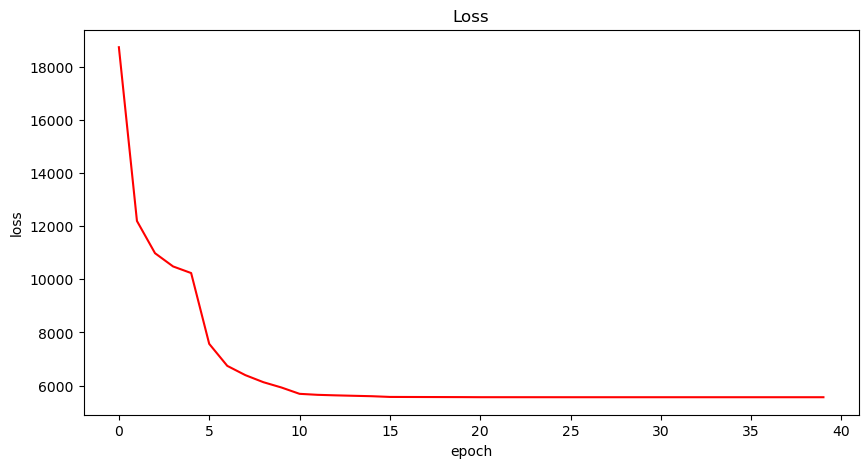

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
plt.xlabel(u'epoch',fontsize=10)
plt.ylabel(u'loss',fontsize=10)
plt.title(u'Loss',fontsize=12)
plt.plot(loss,c = "r")

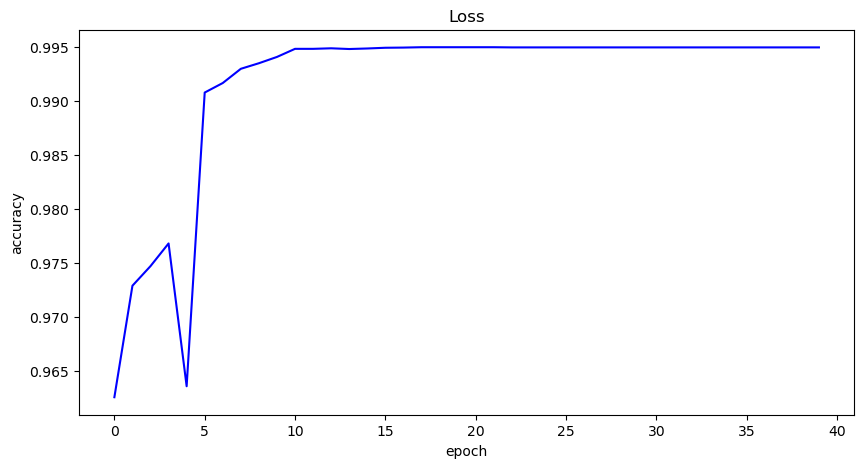

In [45]:
plt.figure(figsize = (10,5))
plt.xlabel(u'epoch',fontsize=10)
plt.ylabel(u'accuracy',fontsize=10)
plt.title(u'Loss',fontsize=12)
plt.plot(accuracy,c='b')